In [1]:
#pip install qutip

In [3]:
import numpy as np
from numpy import transpose, real, sqrt, sin, cos, linalg, cosh, sinh
import scipy
import matplotlib.pyplot as plt
from itertools import combinations
from scipy.optimize import minimize
import time
import sys
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from pprint import pprint
from scipy.linalg import block_diag
import qutip
from qutip import tensor, destroy, create, identity
from qutip import *
from qutip.tensor import tensor
import os

def beep():
    os.system("afplay /System/Library/Sounds/Ping.aiff")

In [4]:
n_modes=8
cutoff=3

#definition of ladder operator generation function(create/destroy on mode i)
def ladder(type,mode,cutoff):     #type=True for destroy(a), =False for create (adag)  #cutoff is the maximum dimension of Fock space for ladder operators
  operator_string=[qeye(cutoff) for _ in range(n_modes)]
  if type==True:
    operator_string[mode-1]=create(cutoff)
  elif type==False:
    operator_string[mode-1]=destroy(cutoff)
  return tensor(operator_string)

print(ladder(True,8,cutoff))

#definition of specific ladder operators:

ladder_ops={'a_alpha_1':ladder(True,1,cutoff),'a_alpha_2':ladder(True,2,cutoff),'a_beta_1':ladder(True,3,cutoff),'a_beta_2':ladder(True,4,cutoff),
     'a_gamma_1':ladder(True,5,cutoff),'a_gamma_2':ladder(True,6,cutoff),'a_delta_1':ladder(True,7,cutoff),'a_delta_2':ladder(True,8,cutoff),
     'adag_alpha_1':ladder(False,1,cutoff),'adag_alpha_2':ladder(False,2,cutoff),'adag_beta_1':ladder(False,3,cutoff),'adag_beta_2':ladder(False,4,cutoff),
     'adag_gamma_1':ladder(False,5,cutoff),'adag_gamma_2':ladder(False,6,cutoff),'adag_delta_1':ladder(False,7,cutoff),'adag_delta_2':ladder(False,8,cutoff)}

print(ladder_ops['adag_alpha_1'])

print(ladder(False,1,cutoff)==ladder_ops['adag_alpha_1'])



Quantum object: dims = [[3, 3, 3, 3, 3, 3, 3, 3], [3, 3, 3, 3, 3, 3, 3, 3]], shape = (6561, 6561), type = oper, isherm = False
Qobj data =
[[0.         0.         0.         ... 0.         0.         0.        ]
 [1.         0.         0.         ... 0.         0.         0.        ]
 [0.         1.41421356 0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 1.         0.         0.        ]
 [0.         0.         0.         ... 0.         1.41421356 0.        ]]
Quantum object: dims = [[3, 3, 3, 3, 3, 3, 3, 3], [3, 3, 3, 3, 3, 3, 3, 3]], shape = (6561, 6561), type = oper, isherm = False
Qobj data =
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
True


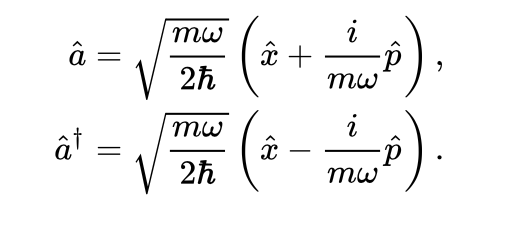



dimensions???!

In [5]:
#define mapping from x,p to ladder operators

labels={'alpha_1':1,'alpha_2':2,'beta_1':3,'beta_2':4,'gamma_1':5,'gamma_2':6,'delta_1':7,'delta_2':8}

inverse_labels = {value: key for key, value in labels.items()}  #this will be useful for the definition of H_el and delta_H

#variables will be defined by a type=('x' or 'p'), and a mode label (string)


def map(type,label):
  if type=='x':
    return (1/np.sqrt(2))*(ladder(True,labels[label],cutoff) + ladder(False,labels[label],cutoff))
  elif type=='p':
    return (1j/np.sqrt(2))*(ladder(False,labels[label],cutoff) - ladder(True,labels[label],cutoff))

pprint(map('p','gamma_2'))



Quantum object: dims = [[3, 3, 3, 3, 3, 3, 3, 3], [3, 3, 3, 3, 3, 3, 3, 3]], shape = (6561, 6561), type = oper, isherm = True
Qobj data =
[[0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 ...
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]]


In [6]:
#construct hamiltonian

def H_plaquette(g_1d,a,mu):
  H_kin=0
  for label in labels:
    H_kin+=(1/2)*(map('p',label)**2)

  #print(H_kin)

  H_b=0
  H_b+= (map('x','beta_1')*map('x','alpha_1')-map('x','beta_2')*map('x','alpha_2')+map('x','gamma_1')*map('x','delta_1')-map('x','gamma_2')+map('x','delta_2'))**2     #first term
  H_b+= (map('x','beta_1')*map('x','alpha_2')+map('x','beta_2')*map('x','alpha_1')+map('x','gamma_1')*map('x','delta_2')+map('x','gamma_2')+map('x','delta_1'))**2    #second term
  H_b*=(g_1d**2)

  H_el=0
  for m in range(1,5):
    H_el+= (map('x',inverse_labels[2*m-1])**2 + map('x',inverse_labels[2*m])**2)**2  #first term
  H_el+=(map('x',inverse_labels[1])**2 + map('x',inverse_labels[2])**2)*(map('x',inverse_labels[7])**2 + map('x',inverse_labels[8])**2)
  H_el-=(map('x',inverse_labels[1])**2 + map('x',inverse_labels[2])**2)*(map('x',inverse_labels[3])**2 + map('x',inverse_labels[4])**2)
  H_el-=(map('x',inverse_labels[5])**2 + map('x',inverse_labels[6])**2)*(map('x',inverse_labels[7])**2 + map('x',inverse_labels[8])**2)
  H_el+=(map('x',inverse_labels[5])**2 + map('x',inverse_labels[6])**2)*(map('x',inverse_labels[3])**2 + map('x',inverse_labels[4])**2)
  H_el*=g_1d**2/(4*a)


  delta_H=0
  #C=(mu*a*g_1d)**2/8
  #D= 2/(a*(g_1d**2))
  for m in range(1,5):
    delta_H+= ((mu*a*g_1d)**2/8)*(map('x',inverse_labels[2*m-1])**2 + map('x',inverse_labels[2*m])**2)**2
    delta_H-=(mu**2*a/4)* (map('x',inverse_labels[2*m-1])**2 + map('x',inverse_labels[2*m])**2)
    #delta_H += (mu*a*g_1d)**2 / (2*a*(2*a*g_1d**2)**2) #this are the corrections, but they depend on g_1d inversely-quadratic
  #print(delta_H)

  return H_kin + H_b + H_el + delta_H

def H_plaquette_with_hc(g_1d,a,mu):
   return H_plaquette(g_1d,a,mu) + 4*(mu*a*g_1d)**2 / (2*a*(2*a*g_1d**2)**2) 

def Hfree(a,mu):
    H_kin=0
    for label in labels:
        H_kin+=(1/2)*(map('p',label)**2)

    decoupledH=0
    for m in range(1,5):
        decoupledH-=(mu**2*a/4)* (map('x',inverse_labels[2*m-1])**2 + map('x',inverse_labels[2*m])**2)

    return H_kin + decoupledH


def Hint(g_1d,a,mu):
      H_b=0
      H_b+= (map('x','beta_1')*map('x','alpha_1')-map('x','beta_2')*map('x','alpha_2')+map('x','gamma_1')*map('x','delta_1')-map('x','gamma_2')+map('x','delta_2'))**2     #first term
      H_b+= (map('x','beta_1')*map('x','alpha_2')+map('x','beta_2')*map('x','alpha_1')+map('x','gamma_1')*map('x','delta_2')+map('x','gamma_2')+map('x','delta_1'))**2    #second term
      H_b*=(g_1d**2)
    
      H_el=0
      for m in range(1,5):
        H_el+= (map('x',inverse_labels[2*m-1])**2 + map('x',inverse_labels[2*m])**2)**2  #first term
      H_el+=(map('x',inverse_labels[1])**2 + map('x',inverse_labels[2])**2)*(map('x',inverse_labels[7])**2 + map('x',inverse_labels[8])**2)
      H_el-=(map('x',inverse_labels[1])**2 + map('x',inverse_labels[2])**2)*(map('x',inverse_labels[3])**2 + map('x',inverse_labels[4])**2)
      H_el-=(map('x',inverse_labels[5])**2 + map('x',inverse_labels[6])**2)*(map('x',inverse_labels[7])**2 + map('x',inverse_labels[8])**2)
      H_el+=(map('x',inverse_labels[5])**2 + map('x',inverse_labels[6])**2)*(map('x',inverse_labels[3])**2 + map('x',inverse_labels[4])**2)
      H_el*=g_1d**2/(4*a)
    
    
      delta_H=0
      #C=(mu*a*g_1d)**2/8
      #D= 2/(a*(g_1d**2))
      for m in range(1,5):
        delta_H+= ((mu*a*g_1d)**2/8)*(map('x',inverse_labels[2*m-1])**2 + map('x',inverse_labels[2*m])**2)**2
        #delta_H += (mu*a*g_1d)**2 / (2*a*(2*a*g_1d**2)**2) #this are the corrections, but they depend on g_1d inversely-quadratic
      #print(delta_H)
      return H_b +H_el + delta_H

def Hint_with_hc(g_1d,a,mu):
    return Hint(g_1d,a,mu) + 4*(mu*a*g_1d)**2 / (2*a*(2*a*g_1d**2)**2)



    
    
    
    
#pprint(H_plaquette(0.001,1,1))


In [7]:
#perform exact diagonalization of hamiltonian
#H=H_plaquette(0.001,1,1)
#gs_energy, gstate = qutip.Qobj.groundstate(H)

#print(gs_energy)

# Sort eigenstates and eigenenergies
#sorted_indices = np.argsort(eigenenergies)
#sorted_eigenstates = [eigenstates[i] for i in sorted_indices]
#sorted_eigenenergies = eigenenergies[sorted_indices]



#for i in range(10):  #print results
    #energy=sorted_eigenenergies[i]
    #state=sorted_eigenstates[i]
    #print(f"Eigenenergy: {energy}")
    #print(f"Eigenstate:\n{state}\n")


In [8]:
#Split hamiltonian

def T():  #kinetic term
  H_kin=0
  for label in labels:
    H_kin+=(1/2)*(map('p',label)**2)
  return H_kin

def V(g_1d,a,mu): #potential term
  H_b=0
  H_b+= (map('x','beta_1')*map('x','alpha_1')-map('x','beta_2')*map('x','alpha_2')+map('x','gamma_1')*map('x','delta_1')-map('x','gamma_2')+map('x','delta_2'))**2     #first term
  H_b+= (map('x','beta_1')*map('x','alpha_2')+map('x','beta_2')*map('x','alpha_1')+map('x','gamma_1')*map('x','delta_2')+map('x','gamma_2')+map('x','delta_1'))**2    #second term
  H_b*=g_1d**2

  H_el=0
  for m in range(1,5):
    H_el+= (map('x',inverse_labels[2*m-1])**2 + map('x',inverse_labels[2*m])**2)**2  #first term
  H_el+=(map('x',inverse_labels[1])**2 + map('x',inverse_labels[2])**2)*(map('x',inverse_labels[7])**2 + map('x',inverse_labels[8])**2)
  H_el-=(map('x',inverse_labels[1])**2 + map('x',inverse_labels[2])**2)*(map('x',inverse_labels[3])**2 + map('x',inverse_labels[4])**2)
  H_el-=(map('x',inverse_labels[5])**2 + map('x',inverse_labels[6])**2)*(map('x',inverse_labels[7])**2 + map('x',inverse_labels[8])**2)
  H_el+=(map('x',inverse_labels[5])**2 + map('x',inverse_labels[6])**2)*(map('x',inverse_labels[3])**2 + map('x',inverse_labels[4])**2)
  H_el*=g_1d**2/(4*a)


  delta_H=0
  #C=(mu*a*g_1d)**2/8
  #D= 2/(a*(g_1d**2))
  for m in range(1,5):
    delta_H+= ((mu*a*g_1d)**2/8)*(map('x',inverse_labels[2*m-1])**2 + map('x',inverse_labels[2*m])**2)**2
    delta_H-=(mu**2*a/4)* (map('x',inverse_labels[2*m-1])**2 + map('x',inverse_labels[2*m])**2)
    #delta_H += (mu*a*g_1d)**2 / (2*a*(2*a*g_1d**2)**2)  #this are the corrections, but they depend on g_1d inversely-quadratic
  return H_b + H_el + delta_H

def V_with_hc(g_1d,a,mu):
    return V(g_1d,a,mu) + 4*(mu*a*g_1d)**2 / (2*a*(2*a*g_1d**2)**2)






In [9]:
#parameters
a=1
mu=1
g_vec = np.arange(0.001,10,0.35)    #free parameter

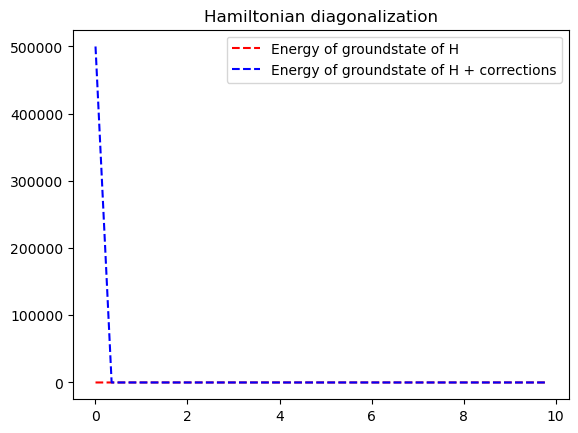

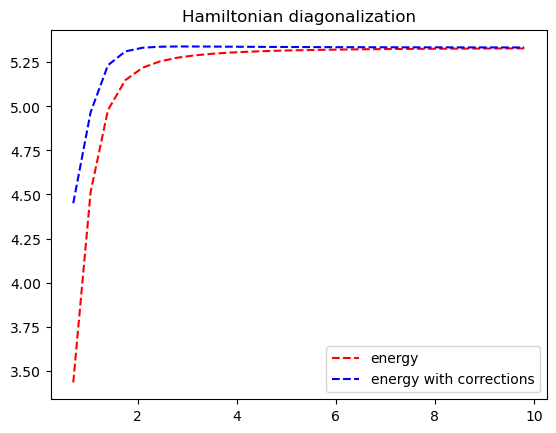

In [10]:
#we diagonalize H total once (exact diagonalization) and store the vector of groundstates for each value of g_1d, so that we can access 
#the values of this vector anytime in the gs_vector

gs_vector=[]
gs_energy_vector=[]
gs_vector_with_hc=[]
gs_energy_vector_with_hc=[]
for i in range(len(g_vec)):
    H= H_plaquette(g_vec[i],a,mu)
    Hhc= H_plaquette_with_hc(g_vec[i],a,mu)
    gs_energy, gs = qutip.Qobj.groundstate(H)
    gs_energyhc, gshc = qutip.Qobj.groundstate(Hhc)
    gs_vector+=[gs]
    gs_energy_vector+=[gs_energy]
    gs_vector_with_hc+=[gshc]
    gs_energy_vector_with_hc+=[gs_energyhc]

#sanity check: see that H with corrections is positive semidefinite (its lowest eigenvalue is greater than 0)

plt.plot(g_vec, gs_energy_vector, 'r--', label='Energy of groundstate of H')
plt.plot(g_vec, gs_energy_vector_with_hc, 'b--', label='Energy of groundstate of H + corrections')
plt.legend()
plt.title('Hamiltonian diagonalization')
plt.show()


plt.plot(g_vec[2:], gs_energy_vector[2:], 'r--', label='energy')
plt.plot(g_vec[2:], gs_energy_vector_with_hc[2:], 'b--', label='energy with corrections')
plt.legend()
plt.title('Hamiltonian diagonalization')
plt.show()
    
beep()





In [11]:
print(gs_vector)
print(gs_energy_vector)
print(gs_vector_with_hc)
print(gs_energy_vector_with_hc)

[Quantum object: dims = [[3, 3, 3, 3, 3, 3, 3, 3], [1, 1, 1, 1, 1, 1, 1, 1]], shape = (6561, 1), type = ket
Qobj data =
[[-0.09731071]
 [ 0.        ]
 [-0.08651576]
 ...
 [-0.04272696]
 [ 0.        ]
 [-0.03798713]], Quantum object: dims = [[3, 3, 3, 3, 3, 3, 3, 3], [1, 1, 1, 1, 1, 1, 1, 1]], shape = (6561, 1), type = ket
Qobj data =
[[-0.25163776]
 [ 0.        ]
 [-0.16806182]
 ...
 [-0.00522321]
 [ 0.        ]
 [-0.00294244]], Quantum object: dims = [[3, 3, 3, 3, 3, 3, 3, 3], [1, 1, 1, 1, 1, 1, 1, 1]], shape = (6561, 1), type = ket
Qobj data =
[[ 8.03689203e-01]
 [ 0.00000000e+00]
 [-1.28810903e-01]
 ...
 [-5.26600032e-05]
 [ 0.00000000e+00]
 [ 3.55333351e-04]], Quantum object: dims = [[3, 3, 3, 3, 3, 3, 3, 3], [1, 1, 1, 1, 1, 1, 1, 1]], shape = (6561, 1), type = ket
Qobj data =
[[ 5.48017897e-01]
 [ 0.00000000e+00]
 [-3.02636653e-01]
 ...
 [-2.07814604e-04]
 [ 0.00000000e+00]
 [ 5.59109677e-04]], Quantum object: dims = [[3, 3, 3, 3, 3, 3, 3, 3], [1, 1, 1, 1, 1, 1, 1, 1]], shape = (6

In [17]:
#Plots

#Function to plot two quantities + the total hamiltonian evolution with the coupling constant

def exact_diagonalization_plot(x,y,labelsy,state_list,energy_list):  #x is the g variable and y is a list of quantities to plot 
    #state_list is the list of ground states at which we calculate the expectation values
    #energy_list is the list of ground state energies of the preoviously diagonalized hamiltonian
    time_in=time.time()


    y1=[]
    y2=[]
    y3=energy_list
    for i in range(len(x)):
      #print('Value of g', x[i])
      y1+=[qutip.expect(y[0][i], state_list[i])] 
      y2+=[qutip.expect(y[1][i], state_list[i])]
      #print(total, kin, pot)
          
    
    plt.plot(x, y1, 'r--', label=labelsy[0])
    plt.plot(x, y2, 'b--', label=labelsy[1])
    plt.plot(x, y3, 'g--', label=labelsy[2])
    plt.legend()
    #plt.set_xlabel('coupling constant g_1d')
    #plt.set_ylabel('Energy')
    plt.title('Hamiltonian diagonalization')
    plt.show()
    
    plt.plot(x[2:], y1[2:], 'r--', label=labelsy[0])
    plt.plot(x[2:], y2[2:], 'b--', label=labelsy[1])
    plt.plot(x[2:], y3[2:], 'g--', label=labelsy[2])
    plt.legend()
    #plt.set_xlabel('coupling constant g_1d')
    #plt.set_ylabel('Energy')
    plt.title('Hamiltonian diagonalization')
    plt.show()

    time_out=time.time()
    beep()
    print(time_out-time_in)
    return




(29, 6561, 6561)
(29, 6561, 6561)
(2, 29, 6561, 6561)


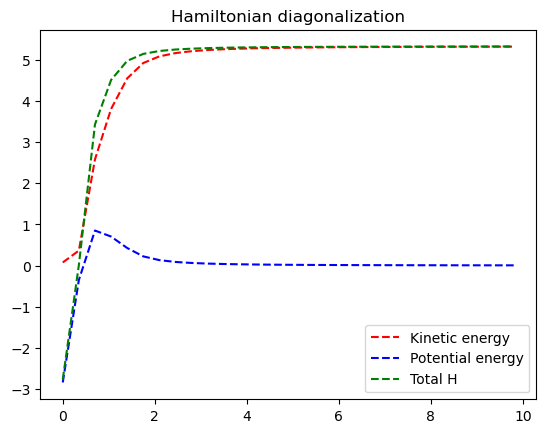

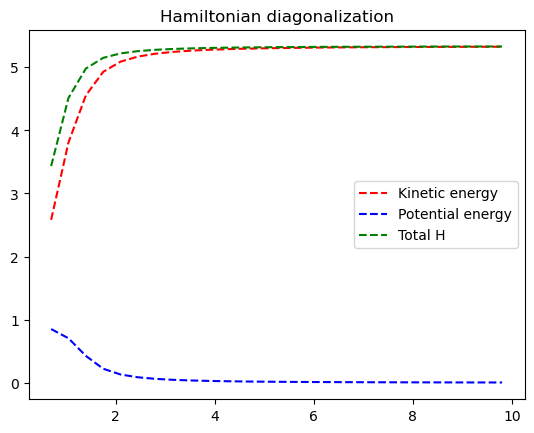

0.26373720169067383


In [18]:
# H,T,V as a function of g in the groundstate of H

y1=[]
for i in range(len(g_vec)):
    y1+=[T()]

print(np.shape(y1))

y2=[]
for i in range(len(g_vec)):
    y2+=[V(g_vec[i],1,1)]

print(np.shape(y2))
print(np.shape([y1,y2]))

exact_diagonalization_plot(g_vec,[y1,y2], ['Kinetic energy', 'Potential energy', 'Total H'], gs_vector, gs_energy_vector)
beep()

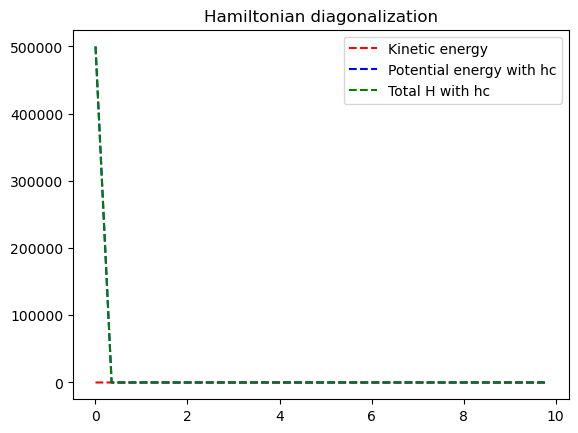

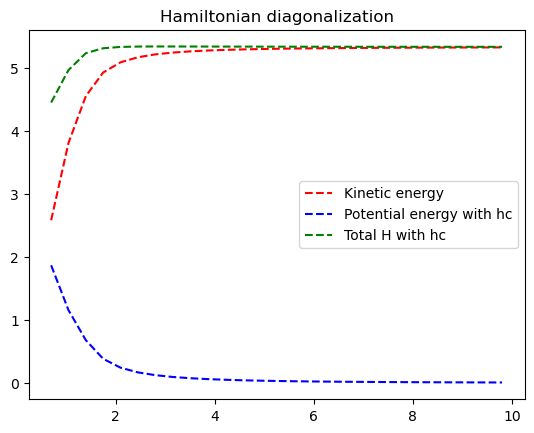

0.2298290729522705


In [20]:
#H_hc, T, V_hc as a function of g in the groundstate of H_hc

y1=[]
for i in range(len(g_vec)):
    y1+=[T()]

y2=[]
for i in range(len(g_vec)):
    y2+=[V_with_hc(g_vec[i],1,1)]

exact_diagonalization_plot(g_vec,[y1,y2], ['Kinetic energy', 'Potential energy with hc', 'Total H with hc'], gs_vector_with_hc, gs_energy_vector_with_hc)
beep()

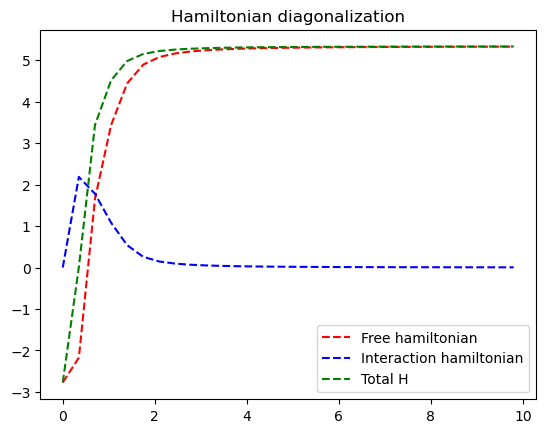

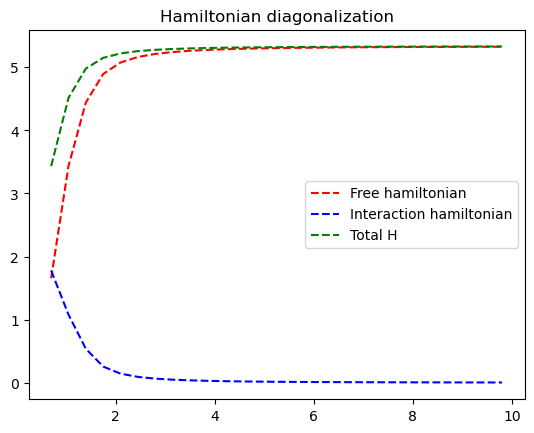

0.2563138008117676


In [21]:
#same two plots but with the splitting in total, free and interaction part (with and without corrections)

#without correcctions
y1=[]
for i in range(len(g_vec)):
    y1+=[Hfree(1,1)]

y2=[]
for i in range(len(g_vec)):
    y2+=[Hint(g_vec[i],1,1)]

exact_diagonalization_plot(g_vec,[y1,y2], ['Free hamiltonian', 'Interaction hamiltonian', 'Total H'], gs_vector, gs_energy_vector)
beep()

In [ ]:
#with corrections
y1=[]
for i in range(len(g_vec)):
    y1+=[Hfree(1,1)]

y2=[]
for i in range(len(g_vec)):
    y2+=[Hint_with_hc(g_vec[i],1,1)]

exact_diagonalization_plot(g_vec,[y1,y2], ['Free hamiltonian', 'Interaction hamiltonian with hc', 'Total H with hc'], gs_vector_with_hc, gs_energy_vector_with_hc)

beep()

In [ ]:
#sanitity check: see that if we take one eigenvector (eg the groundstate for H when g=1 and evolve the expectation value as a function of g 
#we get a cuadratic evolution

#take one random eigenvector of H and the one corresponding to the same g_1d for H_hc
state=gs_vector[5]
state2=gs_vector_with_hc[5]

kin=[]
pot=[]
pot_hc=[]
total=[]
total2=[]

for i in range(len(g_vec)):
  V_operator= V(g_vec[i],1,1)
  T_operator=T()
  H_op=H_plaquette(g_vec[i],1,1)
  Hhc_op=H_plaquette_with_hc(g_vec[i],1,1)
  V_with_hc_operator=V_with_hc(g_vec[i],1,1)

    
  kin+=[qutip.expect(T_operator, state)] 
  pot+=[qutip.expect(V_operator, state)]
  total+=[qutip.expect(H_op,state)]
  
  pot_hc+=[qutip.expect(V_with_hc_operator,state2)]
  total2+=[qutip.expect(Hhc_op,state2)]
    
 
plt.plot(g_vec, kin, 'r--', label='Kinetic energy')
plt.plot(g_vec, pot, 'b--', label='potential energy')
plt.plot(g_vec, total, 'g--', label='Total H')
plt.legend()
plt.title('Operator evolution of a fixed state (no corrections)')
plt.show()

plt.plot(g_vec[2:], kin[2:], 'r--', label='Kinetic energy')
plt.plot(g_vec[2:], pot[2:], 'b--', label='potential energy')
plt.plot(g_vec[2:], total[2:], 'g--', label='Total H')
plt.legend()
plt.title('Operator evolution of a fixed state (no corrections)')
plt.show()

plt.plot(g_vec, kin, 'r--', label='Kinetic energy')
plt.plot(g_vec, pot_hc, 'b--', label='potential energy')
plt.plot(g_vec, total2, 'g--', label='Total H')
plt.legend()
plt.title('Operator evolution of a fixed state (with corrections)')
plt.show()

plt.plot(g_vec[2:], kin[2:], 'r--', label='Kinetic energy')
plt.plot(g_vec[2:], pot_hc[2:], 'b--', label='potential energy')
plt.plot(g_vec[2:], total2[2:], 'g--', label='Total H')
plt.legend()
plt.title('Operator evolution of a fixed state (with corrections)')
plt.show()

beep()

In [ ]:
 #CONMUTATION RELATIONS

def commutator(g_vec,a,mu):  #checks if the potential term, kinetic term and total hamiltonian commute
    comm_H_V = True
    comm_H_T = True
    comm_T_V = True
    for i in range(len(g_vec)):
        #print(qutip.commutator(V(g_vec[i],a,mu),H_plaquette(g_vec[i],a,mu),'normal'))
        if qutip.commutator(V(g_vec[i],a,mu),H_plaquette(g_vec[i],a,mu),'normal') != 0:     
            comm_H_V = False
            print('H and V do not commute')
            break
        else:
            print('operators V and H commute for g=', g_vec[i])
    for i in range(len(g_vec)):
        #print(qutip.commutator(T(),H_plaquette(g_vec[i],a,mu)))
        if qutip.commutator(T(),H_plaquette(g_vec[i],a,mu)) != 0:
            comm_H_T = False
            print('H and T do not commute')
            break
        else:
            print('operators T and H commute for g=', g_vec[i])
    for i in range(len(g_vec)):
        #print(qutip.commutator(T(),V(g_vec[i],a,mu)))
        if qutip.commutator(T(),V(g_vec[i],a,mu)) !=0 :
            comm_T_V = False
            print('V and T do not commute')
            break
        else:
            print('operators T and V commute for g=', g_vec[i])
    if comm_H_V == True and comm_H_T == True and comm_T_V == True:
            print('All three operators commute')
    return


a=1
mu=1
g_vec = np.arange(0,5,0.3)    #free parameter
#commutator(g_vec,a,mu)